<a href="https://colab.research.google.com/github/MrA-png/Cluster-Analysis/blob/main/Cluster_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 1. dataset -> transaction.csv, dan tampilkan
dataset = pd.read_csv('transaction.csv')
dataset.head()

,InvoiceNo,StockCode,Qty,InvoiceDate,CustomerID,Country
0,537626,22725,830,12/7/2010 14:57,12347,Iceland
1,537626,22729,948,12/7/2010 14:57,12347,Iceland
2,537626,22195,695,12/7/2010 14:57,12347,Iceland
3,542237,22725,636,1/26/2011 14:30,12347,Iceland
4,542237,22729,536,1/26/2011 14:30,12347,Iceland


In [20]:
# 2. country -> berapa kemunculan tiap negeri pada dataset, dan tampilkan
country_counts = dataset['Country'].value_counts()
country_counts.head()

,count
Country,
Germany,2269
France,2109
EIRE,1620
Netherlands,634
Spain,539


In [21]:
# 3. transaksi -> hitunglah banyaknya rata-rata jumlah barang (Qty) per transaksi pada tiap
# negara (1 kode InvoiceNo = 1 transaksi)
avg_qty_per_transaction = dataset.groupby(['Country', 'InvoiceNo'])['Qty'].sum().groupby('Country').mean()
avg_qty_per_transaction.head()

,Qty
Country,
Australia,4026.295455
Austria,3420.250000
Bahrain,1470.000000
Belgium,3032.714286
Brazil,4389.000000


In [22]:
# 4. cluster_i[1-10], cluster_val[1-10] -> lakukan clustering pada transaksi dengan K-Means,
# dengan k=3, sebanyak 10 kali. Setiap kali selesai clustering, lakukan cluster analysis dengan
# SSE.
best_sse = float('inf')
best_kmeans = None

for i in range(10):
    kmeans = KMeans(n_clusters=3, random_state=i)
    clusters = kmeans.fit_predict(avg_qty_per_transaction.values.reshape(-1, 1))
    sse = kmeans.inertia_  # Sum of Squared Errors (SSE)
    print(f"Iteration {i + 1} - SSE: {sse}")
    if sse < best_sse:
        best_sse = sse
        best_kmeans = kmeans

Iteration 1 - SSE: 13229107.198522324
Iteration 2 - SSE: 16420994.708162924
Iteration 3 - SSE: 13229107.198522324
Iteration 4 - SSE: 16420994.708162924
Iteration 5 - SSE: 13229107.198522324
Iteration 6 - SSE: 13229107.198522324
Iteration 7 - SSE: 13229107.198522324
Iteration 8 - SSE: 13229107.198522324
Iteration 9 - SSE: 13229107.198522324
Iteration 10 - SSE: 16420994.708162924


In [23]:
# 5. cluster -> ambil cluster_i yang mempunyai cluster_val terkecil
df_clusters_kmeans = pd.DataFrame({
    'Country': avg_qty_per_transaction.index,
    'Avg_Qty_Per_Transaction': avg_qty_per_transaction.values,
    'Cluster': best_kmeans.labels_
})
print("\n Cluster hasil KMeans dengan nilai SSE terkecil:")
print(df_clusters_kmeans.head(), "\n")


 Cluster hasil KMeans dengan nilai SSE terkecil:
     Country  Avg_Qty_Per_Transaction  Cluster
0  Australia              4026.295455        0
1    Austria              3420.250000        0
2    Bahrain              1470.000000        2
3    Belgium              3032.714286        0
4     Brazil              4389.000000        0 



In [24]:
# 6. centroid -> tentukan posisi centroid dari setiap cluster
centroids_kmeans = best_kmeans.cluster_centers_
print("Posisi Centroid dari setiap cluster:")
print(centroids_kmeans, "\n")

Posisi Centroid dari setiap cluster:
[[3542.21952146]
 [6173.85081301]
 [1400.13034188]] 



In [25]:
# 7. sorted -> lakukan pengurutan posisi centroid secara ascending
sorted_centroids_indices = np.argsort(centroids_kmeans.flatten())
print("Indeks centroid setelah pengurutan secara ascending:")
print(sorted_centroids_indices, "\n")

Indeks centroid setelah pengurutan secara ascending:
[2 0 1] 



In [26]:
# 8. Indeks terdepan dari centroid setelah pengurutan, mengindikasikan cluster transaksi rendah.
# Indeks terakhir dari centroid setelah pengurutan, mengindikasikan cluster transaksi tinggi.
# Indeks di antaranya, mengindikasikan cluster transaksi sedang. Tampilkan negara mana saja
# yang transaksinya rendah, sedang dan tinggi.
cluster_map = {sorted_centroids_indices[0]: 'Low',
               sorted_centroids_indices[1]: 'Medium',
               sorted_centroids_indices[2]: 'High'}

df_clusters_kmeans['Transaction Level'] = df_clusters_kmeans['Cluster'].map(cluster_map)
print("Negara dengan tingkat transaksi rendah, sedang, dan tinggi:")
print(df_clusters_kmeans[['Country', 'Avg_Qty_Per_Transaction', 'Transaction Level']], "\n")

Negara dengan tingkat transaksi rendah, sedang, dan tinggi:
                 Country  Avg_Qty_Per_Transaction Transaction Level
0              Australia              4026.295455            Medium
1                Austria              3420.250000            Medium
2                Bahrain              1470.000000               Low
3                Belgium              3032.714286            Medium
4                 Brazil              4389.000000            Medium
5                 Canada              6449.666667              High
6        Channel Islands              4569.714286            Medium
7                 Cyprus              3550.875000            Medium
8         Czech Republic              1239.500000               Low
9                Denmark              3018.888889            Medium
10                  EIRE              3788.866071            Medium
11    European Community               921.666667               Low
12               Finland              3118.000000       

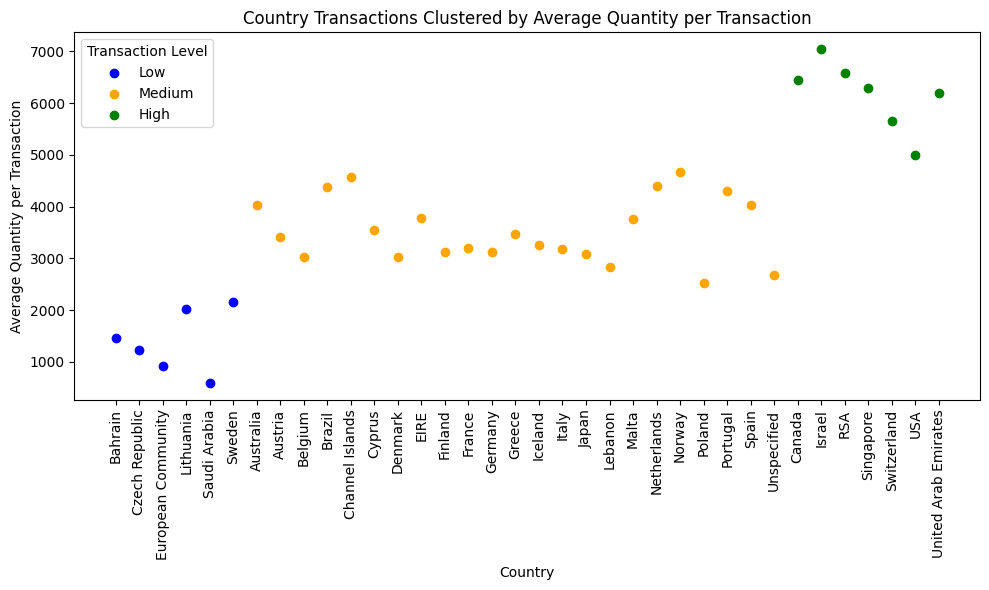

In [27]:
# 9. Visualisasi dengan warna yang berbeda untuk hasil cluster (no. 8), dimana sumbu x=urutan
# country dan sumbu y=transaksi
plt.figure(figsize=(10,6))
colors = {'Low': 'blue', 'Medium': 'orange', 'High': 'green'}

df_clusters_sorted = df_clusters_kmeans.sort_values(by='Country')

for level in colors:
    subset = df_clusters_sorted[df_clusters_sorted['Transaction Level'] == level]
    plt.scatter(subset['Country'], subset['Avg_Qty_Per_Transaction'],
                color=colors[level], label=level)

plt.xlabel('Country')
plt.ylabel('Average Quantity per Transaction')
plt.title('Country Transactions Clustered by Average Quantity per Transaction')
plt.xticks(rotation=90)

plt.legend(title="Transaction Level")
plt.tight_layout()
plt.show()